# RCM modeling with varying reactor volume

This example is available as an ipynb (Jupyter Notebook) file in the main GitHub repository at https://github.com/pr-omethe-us/PyKED/blob/master/docs/rcm-example.ipynb

The ChemKED file that will be used in this example can be found in the
`tests` directory of the PyKED
repository at https://github.com/pr-omethe-us/PyKED/blob/master/pyked/tests/testfile_rcm.yaml.
Examining that file, we find the first section specifies the information about
the ChemKED file itself:

```yaml
file-author:
  name: Kyle E Niemeyer
  ORCID: 0000-0003-4425-7097
file-version: 0
chemked-version: 0.1.6
```

Then, we find the information regarding the article in the literature from which
this data was taken. In this case, the dataset comes from the work of
[Mittal et al.][Mittal2006a]:

```yaml
reference:
  doi: 10.1002/kin.20180
  authors:
    - name: Gaurav Mittal
    - name: Chih-Jen Sung
      ORCID: 0000-0003-2046-8076
    - name: Richard A Yetter
  journal: International Journal of Chemical Kinetics
  year: 2006
  volume: 38
  pages: 516-529
  detail: Fig. 6, open circle
experiment-type: ignition delay
apparatus:
  kind: rapid compression machine
  institution: Case Western Reserve University
  facility: CWRU RCM
```

[Mittal2006a]: https://doi.org/10.1002/kin.20180

Finally, this file contains just a single datapoint, which describes the experimental
ignition delay, initial mixture composition, initial temperature, initial pressure,
compression time, ignition type, and volume history that specifies
how the volume of the reactor varies with time, for simulating the compression
stroke and post-compression processes:

```yaml
datapoints:
- temperature:
    - 297.4 kelvin
  ignition-delay:
    - 1.0 ms
  pressure:
    - 958.0 torr
  composition:
    kind: mole fraction
    species:
      - species-name: H2
        InChI: 1S/H2/h1H
        amount:
          - 0.12500
      - species-name: O2
        InChI: 1S/O2/c1-2
        amount:
          - 0.06250
      - species-name: N2
        InChI: 1S/N2/c1-2
        amount:
          - 0.18125
      - species-name: Ar
        InChI: 1S/Ar
        amount:
          - 0.63125
  ignition-type:
    target: pressure
    type: d/dt max
  compression-time:
    - 38.0 ms
  volume-history:
    time:
      units: s
      column: 0
    volume:
      units: cm3
      column: 1
    values:
      - [0.00E+000, 5.47669375000E+002]
      - [1.00E-003, 5.46608789894E+002]
      - [2.00E-003, 5.43427034574E+002]
      ...
```

The values for the `volume-history` are truncated here to save space. One application of the
data stored in this file is to perform a simulation using [Cantera][Cantera] to
calculate the ignition delay, including the facility-dependent effects represented in the volume
trace. All information required to perform this simulation is present in the ChemKED file, with the
exception of a chemical kinetic model for H<sub>2</sub>/CO combustion.

[Cantera]: http://cantera.org

In Python, additional functionality can be imported into a script or session by the `import`
keyword. Cantera, NumPy, and PyKED must be imported into the session so that we can work with the
code. In the case of Cantera and NumPy, we will use many functions from these libraries, so we
assign them abbreviations (`ct` and `np`, respectively) for convenience. From PyKED, we
will only be using the `ChemKED` class, so this is all that is imported:

In [1]:
import cantera as ct
import numpy as np
from pyked import ChemKED

Next, we have to load the ChemKED file and retrieve the first element of the `datapoints`
list. Although this file only encodes a single experiment, the `datapoints` attribute will
always be a list (in this case, of length 1). The elements of the
`datapoints` list are instances of the [`DataPoint`](https://pr-omethe-us.github.io/PyKED/chemked.html#pyked.chemked.DataPoint) class, which we store in the variable
`dp`. To load the YAML file from the web, we also import and use the [PyYAML package](https://github.com/yaml/pyyaml), and the built-in `urllib` package, and use the `dict_input` argument to `ChemKED` to read the information.

In [2]:
from urllib.request import urlopen
import yaml
rcm_link = 'https://raw.githubusercontent.com/pr-omethe-us/PyKED/master/pyked/tests/testfile_rcm.yaml'
with urlopen(rcm_link) as response:
    testfile_rcm = yaml.safe_load(response.read())
ck = ChemKED(dict_input=testfile_rcm)
dp = ck.datapoints[0]

The initial temperature, pressure, and mixture composition can be read from the
instance of the `DataPoint` class. PyKED uses instances of the Pint `Quantity` class to
store values with units, while Cantera expects a floating-point value in SI
units as input. Therefore, we use the built-in capabilities of Pint to convert
the units from those specified in the ChemKED file to SI units, and we use the `magnitude`
attribute of the `Quantity` class to take only the numerical part. We also retrieve the
initial mixture mole fractions in a format Cantera will understand:

In [3]:
T_initial = dp.temperature.to('K').magnitude
P_initial = dp.pressure.to('Pa').magnitude
X_initial = dp.get_cantera_mole_fraction()

With these properties defined, we have to create the objects in Cantera that represent the physical
state of the system to be studied. In Cantera, the `Solution` class stores the thermodynamic,
kinetic, and transport data from an input file in the CTI format. After the `Solution` object
is created, we can set the initial temperature, pressure, and mole fractions using the `TPX`
attribute of the `Solution` class. In this example, we will use the [GRI-3.0](http://combustion.berkeley.edu/gri-mech/version30/text30.html) as the chemical kinetic mechanism for H<sub>2</sub>/CO combustion. GRI-3.0 is built-in to Cantera, so no other input files are needed.

In [4]:
gas = ct.Solution('gri30.xml')
gas.TPX = T_initial, P_initial, X_initial

With the thermodynamic and kinetic data loaded and the initial conditions defined, we  need to
install the `Solution` instance into an `IdealGasReactor` which implements the equations
for mass, energy, and species conservation. In addition, we create a `Reservoir` to represent
the environment external to the reaction chamber. The input file used for the environment,
`air.xml`, is also included with Cantera and represents an average composition of air.

In [5]:
reac = ct.IdealGasReactor(gas)
env = ct.Reservoir(ct.Solution('air.xml'))

To apply the effect of the volume trace to the `IdealGasReactor`, a `Wall` must be
installed between the reactor and environment and assigned a velocity. The `Wall` allows the
environment to do work on the reactor (or vice versa) and change the reactor's thermodynamic state;
we use a `Reservoir` for the environment because in Cantera, `Reservoir`s always have a
constant thermodynamic state and composition. Using a `Reservoir` accelerates the solution
compared to using two `IdealGasReactor`s, since the composition and state of the environment
are typically not necessary for the solution of autoignition problems. Although we do not show the
details here, a reference implementation of a class that computes the wall velocity given the volume
history of the reactor is available in [CanSen](http://bryanwweber.github.io/CanSen/), in the
[`cansen.profiles.VolumeProfile`](http://bryanwweber.github.io/CanSen/codedocs.html#cansen.profiles.VolumeProfile) class, which we import here:

In [6]:
from cansen.profiles import VolumeProfile
exp_time = dp.volume_history.time.magnitude
exp_volume = dp.volume_history.volume.magnitude
keywords = {'vproTime': exp_time, 'vproVol': exp_volume}
ct.Wall(reac, env, velocity=VolumeProfile(keywords));

Then, the `IdealGasReactor` is installed in a `ReactorNet`. The `ReactorNet`
implements the connection to the numerical solver ([CVODES](https://computation.llnl.gov/projects/sundials/cvodes) is
used in Cantera) to solve the energy and species equations. For this example, it is best practice
to set the maximum time step allowed in the solution to be the minimum time difference in the time array from the volume trace:

In [7]:
netw = ct.ReactorNet([reac])
netw.set_max_time_step(np.min(np.diff(exp_time)))

To calculate the ignition delay, we will follow the definition specified in the ChemKED file for
this experiment, where the experimentalists used the maximum of the time derivative of the pressure
to define the ignition delay. To calculate this derivative, we need to store the state variables and the composition on each time step, so we initialize several Python lists to act as storage:

In [8]:
time = []
temperature = []
pressure = []
volume = []
mass_fractions = []

Finally, the problem is integrated using the `step` method of the `ReactorNet`. The
`step` method takes one timestep forward on each call, with step size determined by the CVODES
solver (CVODES uses an adaptive time-stepping algorithm). On each step, we add the relevant variables
to their respective lists. The problem is integrated until a user-specified end time, in this case
50 ms, although in principle, the user could end the simulation on any condition
they choose:

In [9]:
while netw.time < 0.05:
    time.append(netw.time)
    temperature.append(reac.T)
    pressure.append(reac.thermo.P)
    volume.append(reac.volume)
    mass_fractions.append(reac.Y)
    netw.step()

At this point, the user would post-process the information in the pressure list to calculate
the derivative by whatever algorithm they choose. We will plot the pressure versus the time of the simulation using the Matplotlib library:

<IPython.core.display.Javascript object>


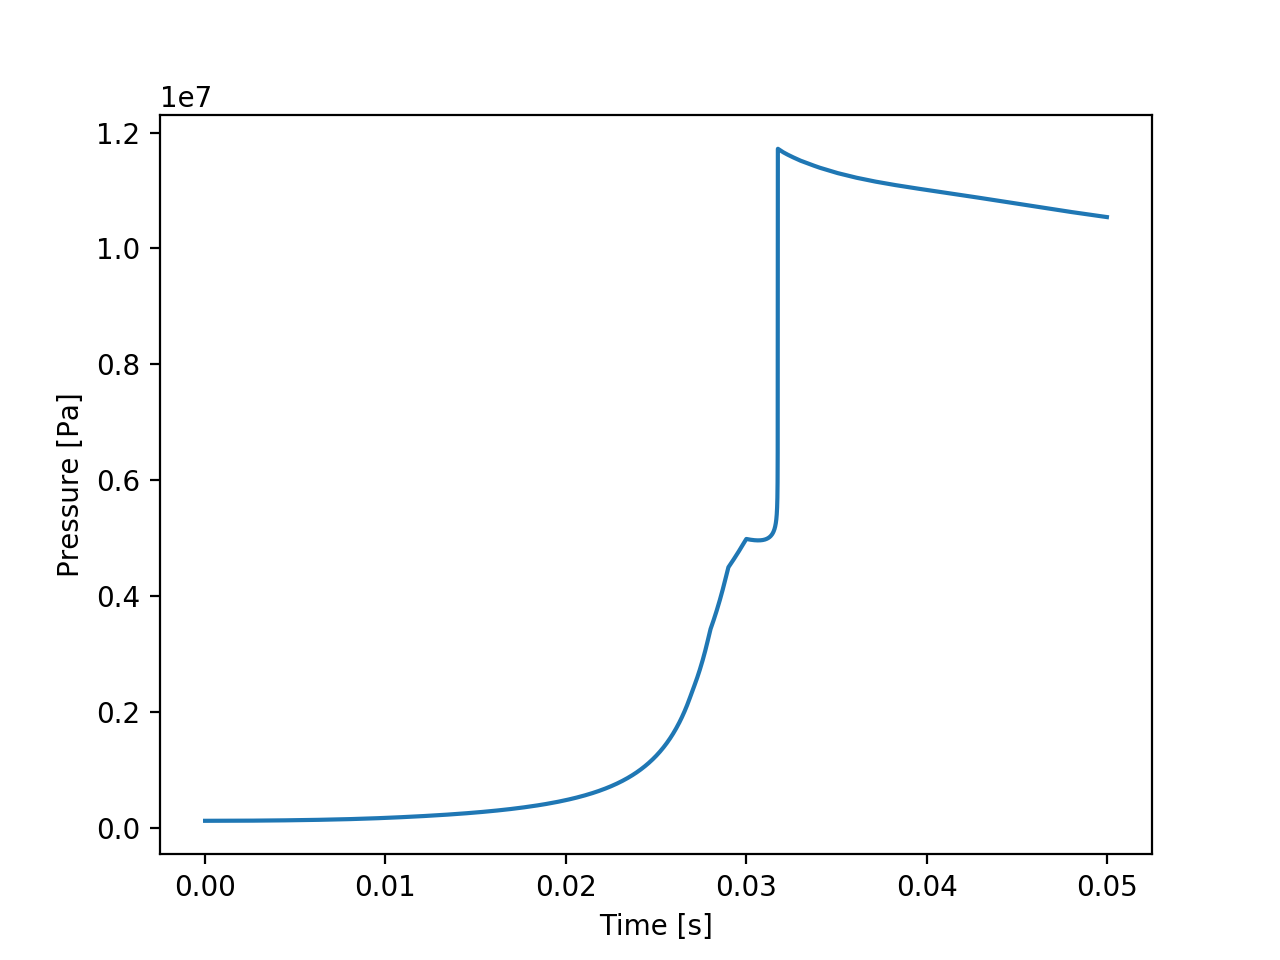

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(time, pressure)
plt.ylabel('Pressure [Pa]')
plt.xlabel('Time [s]');

We can also plot the volume trace and compare to the values derived from the ChemKED file.

<IPython.core.display.Javascript object>


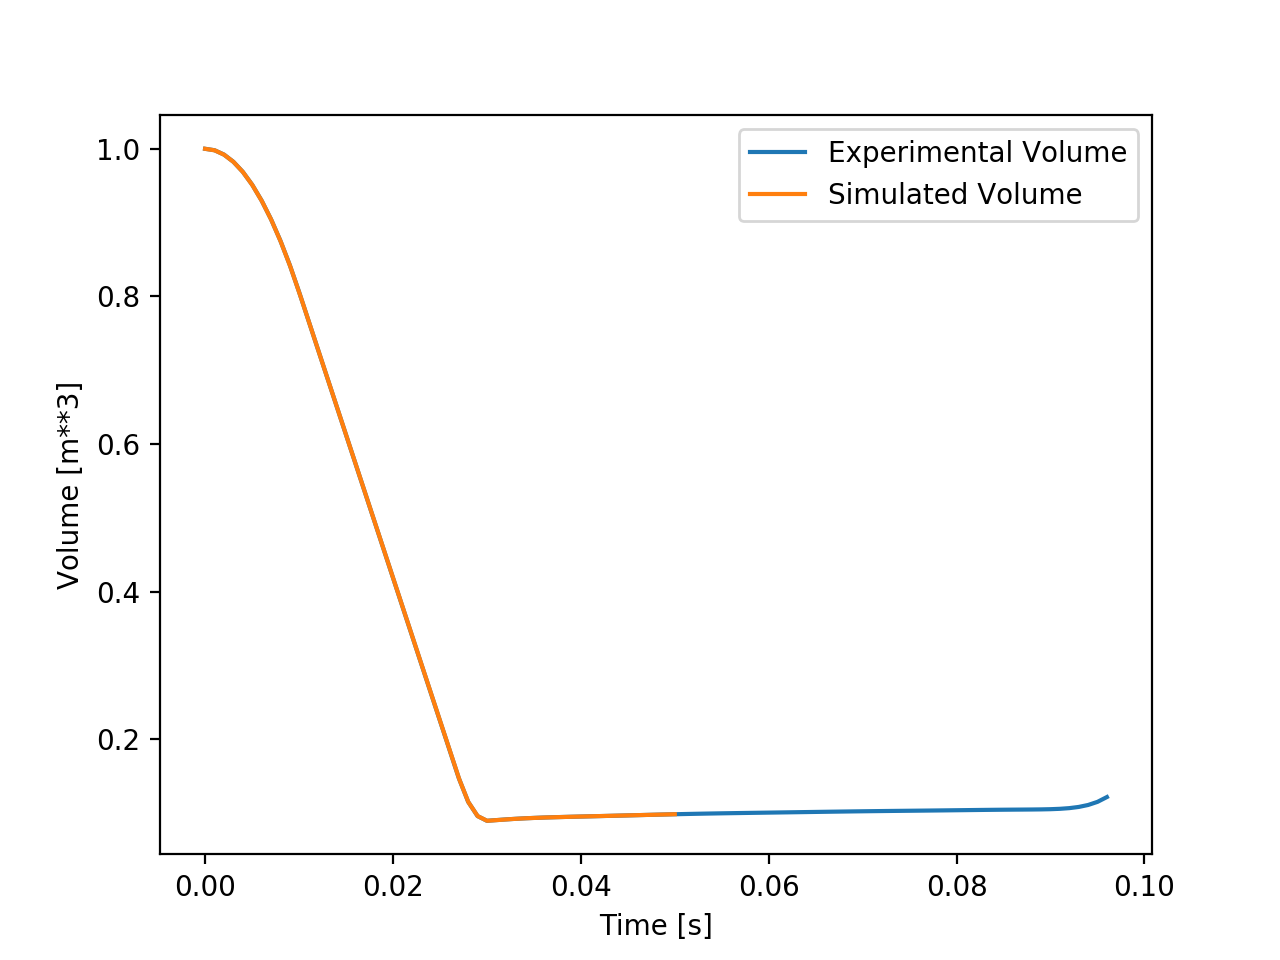

In [11]:
plt.figure()

plt.plot(exp_time, exp_volume/exp_volume[0], label='Experimental volume', linestyle='--')
plt.plot(time, volume, label='Simulated volume')
plt.legend(loc='best')
plt.ylabel('Volume [m^3]')
plt.xlabel('Time [s]');